# **Forest Cover Type Classification**
The forest cover type problem is mainly about classifying the type of trees that cover certain areas. The dataset is taken from 30m by 30m areas of forest that are classified as one of seven cover types:
1. Spruce/Fir
1. Lodgepole Pine
1. Ponderosa Pine
1. Cottonwood/Willow
1. Aspen
1. Douglas-fir
1. Krummholz

Our data set contains a training set of 15,120 examples and a test set of 565,892 examples. As we see the size of the test set is far larger than the size of the training set which make it an intersting challenge to get a model that performs well on the test data. We will start our building our model by importing some libraries and defining some utilities that will be used through this notebook then we will dive into data exploration.

# Imports

In [ ]:
!pip install pytorch-tabnet;
!pip install wget;

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import scatterplotmatrix
from itertools import combinations
import warnings
import gc

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, validation_curve, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

# Utilities

In [ ]:
def outlier_function(df, col_name):
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [ ]:
def evalMod(df, model=LGBMClassifier(n_estimators=2000, max_depth=20, learning_rate=0.05)):
    X_df = df.iloc[:, :-1]
    y_df = df.iloc[:, -1]
    X = df.values[:, :-1]
    y = df.values[:, -1] - 1

    sc = StandardScaler()
    

    kfold = StratifiedKFold(n_splits=5)
    kfold = kfold.split(X, y)
    scores = []
    for k, (train, test) in enumerate(kfold):
        sc.fit(X[train])
        X_train_std = sc.transform(X[train])       
        model.fit(X_train_std, y[train])
        X_test_std = sc.transform(X[test])
        score = accuracy_score(model.predict(X_test_std), y[test])
        scores.append(score)
        #print( score)   
    print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    

In [ ]:
def plotHistograms(df, Feature):
    dct = {1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
    elev = df[Feature]
    cov_type = df['Cover_Type']
    for i in range(df.shape[0]):
        dct[cov_type[i]].append(elev[i])

    plt.figure(figsize=(8,6))
    for i in range(7):
        plt.hist(dct[i+1], bins=100, alpha=0.35, label="Cov_Type"+str(i+1))

    plt.xlabel(Feature, size=14)
    plt.ylabel("Count", size=14)
    plt.title(Feature + "Histograms")
    plt.legend(loc='upper right')
    plt.savefig(Feature + "  Histograms.png")

In [ ]:
def plotStackedHistograms(df, Feature, n_attr):
    dct = {}
    cov_type = df['Cover_Type']
    for i in range(n_attr):
        dct[ Feature +str(i+1)] = [0,0,0,0,0,0,0]

    for i in range(n_attr):
        for j in range(df.shape[0]):
            dct[ Feature+str(i+1)][cov_type[j]-1] += df[Feature+str(i+1)][j]


    XX = tuple(dct.keys())
    YY = np.transpose(np.array(list(dct.values()))).tolist()
    
    dct_type = {}
    for i in range(7):
        dct_type[ "Cover_Type" + str(i+1)] = YY[i]
    
    
    ddff = pd.DataFrame(dct_type, index=pd.Index(XX, name=Feature))
    ax = ddff.plot(kind='bar', stacked=True, figsize=(10, 6))
    ax.set_ylabel('foo')
    plt.legend(title='labels', bbox_to_anchor=(1.0, 1), loc='upper left')
    # plt.savefig('stacked.png')  # if needed
    plt.show()

# Exploratory Data Analysis

We will start our exploration journey by using pandas to read the dataset then display its first examples.

In [ ]:
#read the training data
df = pd.read_csv('../input/forest-cover-type-kernels-only/train.csv.zip')
df.head()

As we see from our output, the attributes of the dataset are as follows:

1- Elevation

Quantitative - measured in meters - its the height of the forest above the sea level

2- Aspect

Quantitative - measured in azimuth degrees - it answers the question of "With respect to the sun, which ways the hill facing?"


3- Slope 

Quantitative - measured in degrees - the slope of the hill


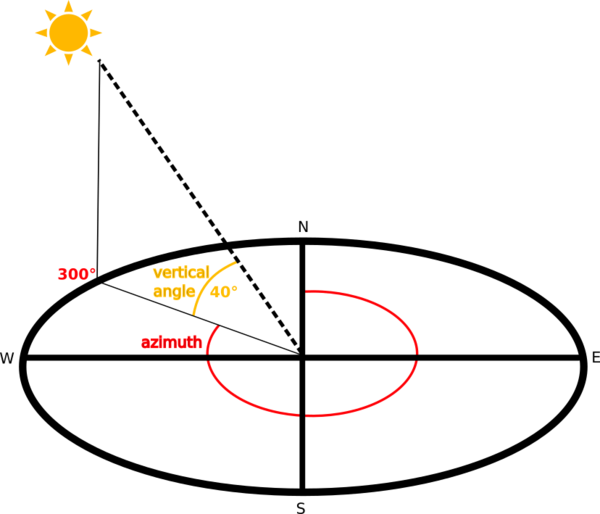

4 - Horizontal Distance To Hydrology	

Quantitative - measured in meters - Horz Dist to nearest surface water features

5 - Vertical Distance To Hydrology

Quantitative - measured in meters - Vert Dist to nearest surface water features

6 - Horizontal Distance To Roadways	

Quantitative - measured in meters - Horz Dist to nearest roadway

7 - Horizontal_Distance_To_Fire_Points 

Quantitative - measured in meters - Horz Dist to nearest wildfire ignition points

8 - Hillshade_9am 

Quantitative - 0 to 255 index - Hillshade index at 9am, summer solstice

9 - Hillshade_Noon 

Quantitative - 0 to 255 index - Hillshade index at noon, summer soltice

10 - Hillshade_3pm 

Quantitative -  0 to 255 index - Hillshade index at 3pm, summer solstice

> Hillshade simulates the shadows cast by the sun upon a three-dimensional representation of terrain

11 - Wilderness_Area 

Qualitative - 0 (absence) or 1 (presence) - 4 binary columns - Wilderness area designation

12 - Soil_Type 

Qualitative - 0 (absence) or 1 (presence) - 40 binary columns - Soil Type designation

13 - Cover_Type 

integer - 1 to 7 - 7 types - Forest Cover Type designation

Next, we will drop the "Id" column as it won't help in modeling.

In [ ]:
df = df.drop(columns='Id')


We shall see brief description of our dataset

In [ ]:
df.describe()

One thing to notice from the description is that the attribute Vertical_Distance_To_Hydrology has negative value. After some searching I found out that negative values of Vertical_Distance_To_Hydrology mean the hydrology lies beneth the specific area of study, positive values mean the hydrology lies above the specific area of study. This information may provide the classifier with some insight but it may also confuses the classifier, thus we will try to eleminate this attribute later and see what happens. 

Let's see if our training data is balanced

In [ ]:
np.bincount(df['Cover_Type'])[1:]

It is balanced training data

To see how many unique values each attribute has we run the following 

In [ ]:
#number of unique values for every feature
df.nunique(axis=0)

In [ ]:
df['Soil_Type7'].sum()

In [ ]:
df['Soil_Type15'].sum()

As we see, the dataset is somewhat diverse, but we also notice that there are no examples of it have Soil_Type7 and Soil_Type15

Next we check if our dataset has some missing values

In [ ]:
if(df.isnull().sum().sum() == 0):
  print('There is no missing values')
else:
  print(df.isnull().sum())

As we see, our dataset has no missing values

Now we can construct the correlation matrix, to see the relationships between the attributes and how they affect each other. One thing to look for is highly correlated features. We shall remove highly correlated features for memory and storage concerns. In addition to that we want to remove any redundant features to avoid the curse of dimensionality and make the feature space more simpler for our model. A rule of thumb is to remove any feature that is correlated with +/- 0.75 or higher with any other feature.

In [ ]:
corr = df.iloc[:, :10].corr()
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(2200,200,as_cmap=True), ax=ax)

From the confusion matrix we could see that there are some correlations, the stongest of them -which exceeded the +/- 0.75 threshold- is Hillshade_9am with Hillshade_3pm. we will more into this when we plot the scatter matrix

It's time to build the scatter matrix! What we are looking for is some kind of correlation, some kind of class seperation based on some those features, we also look for interesting patterns that rise in the dataset and see why they rise.

In [ ]:
sns.set_theme(style="ticks")

sns.pairplot(df.iloc[:, [0,1,2,3,4,5,6,7,8,9,54]], hue='Cover_Type', )

plt.xticks(rotation=90)
    
plt.yticks(rotation=90)

plt.show()

First thing to notice is the Elevation feature. Clearly we can see that it does the best job trying to seperate the classes compared to the other features. 

We can't see any clear seperation in the other features, thus we will try to combine some of them in the feature engineering, hoping to create features that try to seperate the classes better than that.

The correlation between Hillshade_9am and Hillshade_3pm is cleary visible in the plot.

There is some kind of trend between Aspect and Hillshade features, also between Slope and Hillshade features. After some digging it turns out that the hillshade at time t various as a factor of:

                                 cos(slope)cos(90−Altitude)+sin(slope)sin(90−Altitude)cos(Azimuth−Aspect)
                                                         
Altitude is the angle of the Sun relative to the horizon and Azimuth relates to the direction the Sun is facing: North, South, East, or West. Azimuth of 90 degrees corresponds to East.

Now we will look with more details into the distribution of the cover types with respect to every feature in the data set

In [ ]:
for col in list(df.columns[:10]):
    plotHistograms(df, col)

In [ ]:
plotStackedHistograms(df, 'Soil_Type', 40)

In [ ]:
plotStackedHistograms(df, 'Wilderness_Area', 4)

Again observe cleary that elevation does good goob seperating the classes compared to other features, we also observe that Wilderness_Area is constrained with only 3 cover types which make it an important feature seperating the classes.

# Data Cleaning

As observed in the data exploration part there was no missing values and we droped ID column. Two things will be done in the data cleanring section. First thing we will remove highly correlated features and then we will remove outliers. Our approach is to test a baseline model after every modification we do in the data, if the modification improves the accuracy then we keep it, else we undo the modification. I left the modification that I have undone commented to see the effect of it and compare it with other modifications. Also, every modification is evaluated by cross validation score using the function evalMod()

## Evaluating Baseline Model

In [ ]:
print("Cross validation score for the original training data:")
evalMod(df)

## Removing Highly Correlated Features

In [ ]:
df = df.drop(columns='Hillshade_9am')
evalMod(df)

Dropping the feature Hillshade_9am improved the accuracy as expected

## Removing Outliers

An outlier is a data point that is noticeably different from the rest. They represent errors in measurement, bad data collection, or simply show variables not considered when collecting the data. Removing outliers from the training data will make the trained model more robust as it will focus on data that represent the real distribution without any disruption. Our approach to remove outlirs is as stated in this article [https://people.richland.edu/james/lecture/m170/ch03-pos.html](http://)

The outlier_function detects first and third quartile and interquartile range for a given column of a dataframe then calculates upper and lower limits to determine outliers conservatively
returns the number of lower and uper limit and number of outliers respectively


In [ ]:
# loop through all columns to see if there are any outliers
for column in df.columns:
    if outlier_function(df, column)[2] > 0:
        print("There are {} outliers in {}".format(outlier_function(df, column)[2], column))

We will consider the outliers of the quantitative features 
* Horizontal_Distance_To_Fire_Points
* Horizontal_Distance_To_Hydrology
* Vertical_Distance_To_Hydrology
* Hillshade_Noon

In [ ]:
df = df[(df['Horizontal_Distance_To_Fire_Points'] > outlier_function(df, 'Horizontal_Distance_To_Fire_Points')[0]) & (df['Horizontal_Distance_To_Fire_Points'] < outlier_function(df, 'Horizontal_Distance_To_Fire_Points')[1])]
# evalMod(df)
# 80%

In [ ]:
# df = df[(df['Horizontal_Distance_To_Hydrology'] > outlier_function(df, 'Horizontal_Distance_To_Hydrology')[0]) & (df['Horizontal_Distance_To_Hydrology'] < outlier_function(df, 'Horizontal_Distance_To_Hydrology')[1])]
# evalMod(df)
# 79.7%

In [ ]:
# df = df[(df['Vertical_Distance_To_Hydrology'] > outlier_function(df, 'Vertical_Distance_To_Hydrology')[0]) & (df['Vertical_Distance_To_Hydrology'] < outlier_function(df, 'Vertical_Distance_To_Hydrology')[1])]
# evalMod(df)
# 79.7%

In [ ]:
# df = df[(df['Hillshade_Noon'] > outlier_function(df, 'Hillshade_Noon')[0]) & (df['Hillshade_Noon'] < outlier_function(df, 'Hillshade_Noon')[1])]
# evalMod(df)
# 79.6%

Removing the outliers of Horizontal_Distance_To_Fire_Points generated a decent improvement in accuracy. But for the other features there weren't any improvments at all, thus we I have undone these modifications. It could be justified as these outliers of Horizontal_Distance_To_Hydrology, Vertical_Distance_To_Hydrology and Hillshade_Noon holds some other valuable information for the classifier, and getting rid of them means also getting rid of these valuable information, so we just keep them. 

# Feature Engineering


Now comes the interesting part, Feature Engineering. We will try to make use of the observations we obtained from visualizing the data to create new features that help the model to seperate will between the classes. As we remember, there wasn't enough good seperation between the classess in almost all the features except for the Elevation feature, thus we will try to make some meaningful combination of the features to enhance the seperation. Our approach as stated before is to evluate the performance of every step we do in feature engineering and undone this step if it leads to worse accuracy.

In [ ]:
df.insert(0, 'Hydro_Dist', np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2))
df.insert(0, 'HydroRoad_horz', df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Roadways'])
df.insert(0, 'HydroFire_horz', df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Fire_Points'])
df.insert(0, 'FireRoad_horz', df['Horizontal_Distance_To_Roadways']+df['Horizontal_Distance_To_Fire_Points'])
# evalMod(df)
# 80.6%

In [ ]:
# df.insert(0, 'HydroRoad_Vert', np.abs(df['Vertical_Distance_To_Hydrology'])+df['Horizontal_Distance_To_Roadways'])
# df.insert(0, 'HydroFire_Vert', np.abs(df['Vertical_Distance_To_Hydrology'])+df['Horizontal_Distance_To_Fire_Points'])
# evalMod(df)
# 80.3%

In [ ]:
df.insert(0, 'HydroRoad_horz_diff', abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Roadways']))
df.insert(0, 'HydroFire_horz_diff', abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Fire_Points']))
df.insert(0, 'FireRoad_horz_diff', abs(df['Horizontal_Distance_To_Roadways'] - df['Horizontal_Distance_To_Fire_Points']))
# evalMod(df)
# 81.2%

In [ ]:
df.insert(0, 'HydroRoad_horz_ratio', df['Horizontal_Distance_To_Hydrology'] / (df['Horizontal_Distance_To_Roadways'] + 1))
df.insert(0, 'HydroFire_horz_ratio', df['Horizontal_Distance_To_Hydrology'] / (df['Horizontal_Distance_To_Fire_Points'] + 1))
df.insert(0, 'FireRoad_horz_ratio', df['Horizontal_Distance_To_Roadways'] / (df['Horizontal_Distance_To_Fire_Points'] + 1))
# evalMod(df)
# 81.3%

In [ ]:
# df.insert(0, 'Hydro_Vert_abs', np.abs(df['Vertical_Distance_To_Hydrology']))
# df = df.drop(columns='Vertical_Distance_To_Hydrology')
# evalMod(df)
# 81%

In [ ]:
# df.insert(0, 'Hishade_mean',  (df['Hillshade_Noon'] + df['Hillshade_3pm']) / 2)
# evalMod(df)
# 80.%

In [ ]:
# df.insert(0, 'Hishade_max',  np.max( [list(df['Hillshade_Noon']), list(df['Hillshade_3pm'])], axis=0))
# evalMod(df)
# 80.6%

In [ ]:
# df.insert(0, 'Hishade_ratio',  df['Hillshade_3pm'] / df['Hillshade_Noon'])
# evalMod(df)
# 80.9%

In [ ]:
df.insert(0, 'Elevation_log',  np.log(df['Elevation']))
#evalMod(df)
# 81.3% +/- 0.036

In [ ]:
df.insert(0, 'Elevation_inv',  1/ df['Elevation'])
# evalMod(df)
# 81.4% +/- 0.033

In [ ]:
# df.insert(0, 'ElevHydro_vert', df['Elevation'] + df['Vertical_Distance_To_Hydrology'])
# evalMod(df)
# 81.1%

In [ ]:
# df = df.drop(columns='ElevHydro_vert')

In [ ]:
# df.insert(0, 'ElevHydro_vert', df['Elevation'] + np.abs(df['Vertical_Distance_To_Hydrology']))
# evalMod(df)
# 81.1%

In [ ]:
# df = df.drop(columns='ElevHydro_vert')

In [ ]:
# df.insert(0, 'ElevHydro_vert', df['Elevation'] + 4*np.abs(df['Vertical_Distance_To_Hydrology']))
# evalMod(df)
# 81.3% +/- 0.035

In [ ]:
df.insert(0, 'Angle', (np.arctan(df['Slope']) / np.pi) * 180)
df = df.drop(columns='Slope') #no effect when removing
# evalMod(df)
# 81.4% +/- 0.032 best

In [ ]:
# df.insert(0, 'AspectAngle_ratio', (df['Aspect']+1) / (df['Angle']+1))
# evalMod(df)
# 81.2% 

In [ ]:
df.iloc[:,:15].describe()

As expected, different combinations of Horizontal_Distance_To_Hydrology, Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways, Horizontal_Distance_To_Fire_Points improved the performance a lot. In addtion to that, we made use of our observation of the elevation feature importance and added its log and its inverse to the features. Accidentally, I took the arctan() of the slope angle instead of calculating it tan(), but it was a good accident! Surprisingly, the arctan of the slope performed better than the slope itself, the arctan of the slope doesn't make much sense, but in any case it performed better and made sense for the classifier, thus I decided to keep it. This could be justified, the arctan of the slope angle is a function of the slope angle, this function gives us new feature that provides -in combination with the other features- a clearer seperation between the classes. 



# Model Selection and Optimization


Now comes the model selection section. In this section will we evaluate the models that perform well in structured data. It's known that tree based methods are the state of the art when we are talking about structured data thus we will train and evaluate LightGBM, XGboost, Random Forests and ExtraTreeClassifier. We won't use tree methods only, Neural Networks is thought to give a promising performance in this problem so we will also train and evaluate fully connected neural networks and its new variation TabNet. Linear models like logistic regression and support vector machines didn't perform well in this problem so I won't consider them in my final submission. 

For the tree-based methods I will sklearn interface. For neural networks and tabnet I will use pytorch. The models hyberparameters were optimized manually by conducting alot of different trails on each model,the models were evaluated using cross validation score during hyberparameter optimization as it provides more accurate result with no bias.


In [ ]:
# train-test split
X = df.values[:, :-1]
y = df.values[:, -1] - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

#For Voting Classifier
preds = pd.DataFrame()

## LightGBM


In [ ]:
#fit lightGBM
lgbm = LGBMClassifier(n_estimators=2000, max_depth=20, learning_rate=0.06, min_child_samples=20, reg_alpha=0 , reg_lambda=0.001, subsample=0.8, colsample_bytree=.6, subsample_for_bin=1000)
lgbm.fit(X_train_std, y_train)
preds['lgbm'] = lgbm.predict(X_test_std)
print("lgbm", accuracy_score(preds['lgbm'].values , y_test))
del lgbm

## XGBoost

In [ ]:
#fit xgboost
xgb = XGBClassifier(n_estimators=2000, max_depth=20, learning_rate=0.05, use_label_encoder=False, verbosity = 0)
xgb.fit(X_train_std, y_train)
preds['xgb'] = xgb.predict(X_test_std)
print("xgb", accuracy_score(preds['xgb'].values , y_test))
del xgb

## Random Forest

In [ ]:
#fit randomForest
forest = RandomForestClassifier(n_estimators=3000, max_depth=20)
forest.fit(X_train_std, y_train)
preds['forest'] = forest.predict(X_test_std)
print("forest", accuracy_score(preds['forest'].values , y_test))
del forest

## ExtraTreeClassifier

In [ ]:
#fit extraTrees
extraTrees = ExtraTreesClassifier(n_estimators=5000, max_depth=50, criterion='entropy')
extraTrees.fit(X_train_std, y_train)
preds['extraTrees'] = extraTrees.predict(X_test_std)
print("extraTrees", accuracy_score(preds['extraTrees'].values , y_test))
del extraTrees

LightGBM and XGBoost are different implementations of Gradient Boosting Decision Trees (GBDT), these are ensemble models that are based on boosting, which means building stronger models from weaker models. LightGBM provies faster and parallelized implementation in which the tree grows in leaf-wise approach. Whereas XGBoost is slower and its trees grow in level-wise approch. 

Random Forest and ExtraTreeClassifier are kinda similar. Both of them build randomized trees, every tree is built with subset of features and subset of training data. Then in test time voting is done between the decision tree to determine the correct class. The difference between them is as follows, Random forest uses bootstrap replicas, that is to say, it subsamples the input data with replacement, whereas Extra Trees use the whole original sample. Another difference is the selection of cut points in order to split nodes. Random Forest chooses the optimum split while Extra Trees chooses it randomly. However, once the split points are selected, the two algorithms choose the best one between all the subset of features. Therefore, Extra Trees adds randomization but still has optimization. 

As it is observed the performance of these 4 models is quite similar with ExtraTreeClassifier having the lead.

## Neural Networks

In [ ]:
class ForestCoverDataset(Dataset):

    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        sample_features = self.X[idx]
        sample_label = self.y[idx]
        sample = {'sample_features': sample_features, 'sample_label':sample_label}
        return sample  

In [ ]:
# Network class
class NN(nn.Module):
  #best 800 hidden units
  def __init__(self, input_size, num_classes):
    super(NN,self).__init__()

    self.fc1 = nn.Linear(input_size, 1600)
    self.fc1_bn = nn.BatchNorm1d(1600)
    self.dropout1 = nn.Dropout(p=0.5)
    
    self.fc2 = nn.Linear(1600, 200)
    self.fc2_bn = nn.BatchNorm1d(200)
    self.dropout2 = nn.Dropout(p=0.5)

    
    self.fc3 =  nn.Linear(200, num_classes)
    self.fc3_bn = nn.BatchNorm1d(num_classes)

  def forward(self,x):
    x = F.leaky_relu(self.dropout1(self.fc1_bn(self.fc1(x))))
    x = F.leaky_relu(self.dropout2(self.fc2_bn(self.fc2(x))))
    x = self.fc3_bn(self.fc3(x))
    return x

In [ ]:
def multi_acc(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim=1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
  correct_pred = (y_pred_tags == y_test).float()
  acc = correct_pred.sum() / len(correct_pred)
  acc = acc * 100
  return acc

In [ ]:
def train_model(train_loader, test_loader, model, optimizer, criterion, num_epochs, device='cpu', validation=True): 
    accuracy_stats = {'train': [], 'val': []}
    loss_stats = {'train': [], 'val': []}
    for e in tqdm(range(1, num_epochs+1)):
        #training
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()

        for data in train_loader:
            X_train_batch = data['sample_features']
            y_train_batch = data['sample_label']
            X_train_batch = X_train_batch.to(device=device)
            y_train_batch = y_train_batch.to(device=device)

            optimizer.zero_grad()

            y_train_pred = model(X_train_batch)

            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)

            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
        
        #validation
        if(validation):        
            with torch.no_grad():
                val_epoch_loss = 0
                val_epoch_acc = 0

                model.eval()

                for data_test in test_loader:
                    X_test_batch = data_test['sample_features']
                    y_test_batch = data_test['sample_label']
                    X_test_batch = X_test_batch.to(device=device)
                    y_test_batch = y_test_batch.to(device=device)

                    y_test_pred = model(X_test_batch)

                    val_loss = criterion(y_test_pred, y_test_batch)
                    val_acc = multi_acc(y_test_pred, y_test_batch)

                    val_epoch_loss += val_loss.item()
                    val_epoch_acc += val_acc.item()

            loss_stats['train'].append(train_epoch_loss/len(train_loader))
            loss_stats['val'].append(val_epoch_loss/len(test_loader))
            accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
            accuracy_stats['val'].append(val_epoch_acc/len(test_loader))
            if(e % 25 == 0 or e == 1):
                print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader) : .5f} | Val Loss: {val_epoch_loss/len(test_loader):.5f}  | Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc:  {val_epoch_acc/len(test_loader):.3f}')
    return model, accuracy_stats, loss_stats

In [ ]:
def evalNet(model, X_test, device='cpu'):
    with torch.no_grad():
        model.eval()
        y_test_pred = model(torch.from_numpy(X_test).float().to(device))
        y_pred_softmax = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
    return y_pred_tags.cpu().numpy()

In [ ]:
nn_train_data = ForestCoverDataset(torch.from_numpy(X_train_std).float(), torch.from_numpy(y_train).long())
nn_test_data = ForestCoverDataset(torch.from_numpy(X_test_std).float(), torch.from_numpy(y_test).long())


num_epochs = 1000
train_batch_size = 128
test_batch_size = len(nn_test_data)
learning_rate = 0.005
num_features = 65
num_classes = 7
device = 'cuda'

train_loader = DataLoader(nn_train_data, 
                          batch_size=train_batch_size,
                          shuffle=True)

test_loader = DataLoader(nn_test_data, 
                          batch_size=test_batch_size,
                          shuffle=True)

model = NN(input_size=num_features, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device=device)
trained_model, accuracy_stats, loss_stats = train_model(train_loader, test_loader, model, optimizer, criterion, num_epochs, device='cuda', validation=True)
preds['net'] = evalNet(model, X_test_std, 'cuda')
print("net", accuracy_score(preds['net'].values , y_test))
del trained_model, model, accuracy_stats, loss_stats

## TabNet

TabNet is a deep neural network specialized to deal with tabular data. It consists of sevaral steps, every step contains two blocks:

The Feature Transformer block is used to process the features

The Attentive Transformer block is used for automatic feature selection

More info could be found here https://arxiv.org/abs/1908.07442


In [ ]:
tabnet = TabNetClassifier(
    n_d=64, n_a=64, n_steps=8,
    gamma=1.5, n_independent=2, n_shared=2,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

max_epochs = 500

tabnet.fit(
    X_train=X_train_std, y_train=y_train,
    max_epochs=max_epochs, patience=500,
    batch_size=512, virtual_batch_size=128
) 

y_pred= tabnet.predict(X_test_std)
print("tabnet", accuracy_score(y_pred , y_test))
del tabnet

We see that the accuracy in the neural net models are higher than the tree-based models, but it doesn't reflect the truth as we use cross validation with tree-based methods whcih is more reliable than the validation set we use with the neural net models. In the next model (Voting Classifier) we will establish a fair comparison between these models. 

## Voting Classifier

We can make a stronger classifier if we united our chosen classifiers together. This could be done a Voting Classifier. Simply we will train our all of our chosen models and in test time we will make predictions with all of our chosen models, then for each test example we will get its prediction from all of the models, the test example will be asigned to a particular class according to the majority voting of all the models. This is called Hard Voting.

All of the previous models will be chosen except for TabNet. As we saw, ExtraTreesClassifier achieved the best results, with LightGBM, XGBoost and Neural Network achieved quite good and similar results, RandomForest achieved lower results but it is still comparable to the previous classifiers, when it comes to TabNet, it took so long to be trained and generated worest result of them all, thus we get rid of it in favor of achieving better training and testing time and also to constrain the voting to reliable models.

Now we will compare the performance of our Voting Classifier with the performance of the other models. We won't do it using cross validation as we don't have enough time for it. so we will split our training data and get validation set to compare the results. Of course cross validation assures that our model isn't biased towards part of the examples in the dataset but using a validation set still generates somewhat reliable result.


In [ ]:
### Voting ###
y_pred = preds.mode(axis=1).values[:,0]
print("Voting", accuracy_score(y_pred , y_test))

The ExtraTreeClassifier outperforms all other models and also outperforms the Voting classifier! It turns out that the ExtraTreeClassifier classifier managed to correctly classify hard test examples that all other classes failed to do classifiy correctly, in the final submission I submited one time the voting classifier and obtained 79.75% but with the ExtraTreeClassifier I obtained 80.7%, which makes it a clear winner!

# Submission

In [ ]:
# Reading the entire training data
X = df.values[:, :-1]
y = df.values[:, -1] - 1
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

In [ ]:
# Training ExtraTrees Classifier
extraTrees = ExtraTreesClassifier(n_estimators=5000, max_depth=50, criterion='entropy')
extraTrees.fit(X_std, y)
print("ExtraTrees Done!")

In [ ]:
# Preprocess Test Data
df_submit = pd.read_csv('../input/forest-cover-type-kernels-only/test.csv.zip')
id_submit = df_submit.values[:, 0]
df_submit = df_submit.drop(columns='Id')

df_submit = df_submit.drop(columns='Hillshade_9am')
df_submit.insert(0, 'Hydro_Dist', np.sqrt(df_submit['Horizontal_Distance_To_Hydrology']**2 + df_submit['Vertical_Distance_To_Hydrology']**2))
df_submit.insert(0, 'HydroRoad_horz', df_submit['Horizontal_Distance_To_Hydrology'] + df_submit['Horizontal_Distance_To_Roadways'])
df_submit.insert(0, 'HydroFire_horz', df_submit['Horizontal_Distance_To_Hydrology'] + df_submit['Horizontal_Distance_To_Fire_Points'])
df_submit.insert(0, 'FireRoad_horz', df_submit['Horizontal_Distance_To_Roadways'] + df_submit['Horizontal_Distance_To_Fire_Points'])
df_submit.insert(0, 'HydroRoad_horz_diff', abs(df_submit['Horizontal_Distance_To_Hydrology'] - df_submit['Horizontal_Distance_To_Roadways']))
df_submit.insert(0, 'HydroFire_horz_diff', abs(df_submit['Horizontal_Distance_To_Hydrology'] - df_submit['Horizontal_Distance_To_Fire_Points']))
df_submit.insert(0, 'FireRoad_horz_diff', abs(df_submit['Horizontal_Distance_To_Roadways'] - df_submit['Horizontal_Distance_To_Fire_Points']))
df_submit.insert(0, 'HydroRoad_horz_ratio', df_submit['Horizontal_Distance_To_Hydrology'] / (df_submit['Horizontal_Distance_To_Roadways'] + 1))
df_submit.insert(0, 'HydroFire_horz_ratio', df_submit['Horizontal_Distance_To_Hydrology'] / (df_submit['Horizontal_Distance_To_Fire_Points'] + 1))
df_submit.insert(0, 'FireRoad_horz_ratio', df_submit['Horizontal_Distance_To_Roadways'] / (df_submit['Horizontal_Distance_To_Fire_Points'] + 1))
df_submit.insert(0, 'Elevation_log',  np.log(df_submit['Elevation']))
df_submit.insert(0, 'Elevation_inv',  1/ df_submit['Elevation'])
df_submit.insert(0, 'Angle', (np.arctan(df_submit['Slope']) / np.pi) * 180)
df_submit = df_submit.drop(columns='Slope') #no effect when removing
df_submit.head()

In [ ]:
id_submit.shape

In [ ]:
X_submit = df_submit.values
X_submit_std = sc.transform(X_submit)


print("Evaluation..")
preds = pd.DataFrame()
y_submit = extraTrees.predict(X_submit_std)

submission = {'Id':id_submit, 'Cover_Type': (y_submit + 1).astype(int)}
df_submission = pd.DataFrame(submission)
df_submission.to_csv('submission.csv', index=False)

# Conclusion of the previous steps

In the beginning we explored the dataset which contains 10 quantitative features and two categorical features onehot-encoded into 4 and 40 binary features respectively. We observed from the visualization of the data that there some correlation between the hillshade features thus we removed one of them. We also removed the outliers that make our model perform worse. In addition to that we generated some new features from combinations of the existed features, all of made our data better for the models. We trained several machine learning algorithms but from all the tree based methods achieved the highest accuracy, specially ExtraTreeClassifier which outperorms all other classifiers and also outperformed the voting classifier. We used used this ExtraTreeClassifier for our final submission and obtained 80.7%.